In [ ]:
!pip install -U diffusers

In [ ]:
from huggingface_hub import login
login(new_session=False)

## Remote Inference via Inference Providers
Ensure you have a valid **HF_TOKEN** set in your environment. You can get your token from [your settings page](https://huggingface.co/settings/tokens). Note: running this may incur charges above the free tier.
The following Python example shows how to run the model remotely on HF Inference Providers, automatically selecting an available inference provider for you.
For more information on how to use the Inference Providers, please refer to our [documentation and guides](https://huggingface.co/docs/inference-providers/en/index).

In [ ]:
!pip install bitsandbytes

In [ ]:
!pip install invisible_watermark transformers accelerate safetensors


model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

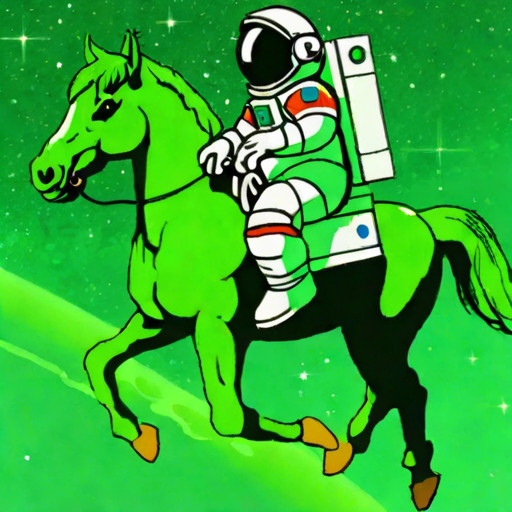

In [5]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/sdxl-turbo")
pipe.to("cuda")

# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()

prompt = "An astronaut riding a green horse"

images = pipe(prompt=prompt).images[0]
images


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install trl.trainer

ERROR: Could not find a version that satisfies the requirement trl.trainer (from versions: none)
ERROR: No matching distribution found for trl.trainer


In [ ]:
!pip install transformers

In [ ]:

import torch
import json
import os
from datasets import Dataset
from PIL import Image
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from transformers import AutoTokenizer, BitsAndBytesConfig
from torch.utils.data import DataLoader
from accelerate import Accelerator
from peft import LoraConfig, get_peft_model
import torchvision.transforms as T
import bitsandbytes.optim as bnb

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- Initialize Accelerator ---
accelerator = Accelerator(mixed_precision="fp16", gradient_accumulation_steps=4)
device = accelerator.device
print(f"Using device: {device}")

# Verify GPU availability
if not torch.cuda.is_available():
    raise RuntimeError("GPU not available. Ensure Colab is set to GPU runtime.")

# --- Load SDXL ---
model_id = "stabilityai/sdxl-turbo"
# ---- 4-bit quantisation config (new API) ----
quant_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)
pipe = DiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    load_in_4bit=True
)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to(device)

# Load tokenizers and text encoders
tokenizer_one = AutoTokenizer.from_pretrained(model_id, subfolder="tokenizer")
tokenizer_two = AutoTokenizer.from_pretrained(model_id, subfolder="tokenizer_2")
text_encoder_one = pipe.text_encoder
text_encoder_two = pipe.text_encoder_2
text_encoder_one.to(device)
text_encoder_two.to(device)

# --- LoRA on UNet ---
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.1,
    bias="none"
)
pipe.unet = get_peft_model(pipe.unet, lora_config)
pipe.unet.enable_gradient_checkpointing()

# --- Load dataset (limit to 500 images) ---
dataset_path = "./drive/MyDrive/cc_data/cc_data"
image_dir = os.path.join(dataset_path, "images")
jsonl_path = os.path.join(dataset_path, "dataset.jsonl")

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset directory not found at {dataset_path}")
if not os.path.exists(jsonl_path):
    raise FileNotFoundError(f"JSONL file not found at {jsonl_path}")

print(f"Dataset directory: {dataset_path}")
print(f"JSONL file: {jsonl_path}")

data = []
with open(jsonl_path, "r") as f:
    for i, line in enumerate(f):
        if i < 3:
            print(f"Line {i+1}: {line.strip()}")
        try:
            entry = json.loads(line.strip())
            prompt_key = "text"  # Confirmed from output
            image_key = "image_path"  # Confirmed from output
            if prompt_key in entry and image_key in entry:
                image_path = os.path.join(image_dir, os.path.basename(entry[image_key]))
                if os.path.exists(image_path):
                    data.append({"prompt": entry[prompt_key], "image_path": image_path})
                else:
                    print(f"Warning: Image not found: {image_path}")
                if len(data) >= 100:
                    break
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON on line {i+1}: {e}")
if not data:
    raise ValueError("No valid data loaded from dataset.jsonl")
print(f"Loaded {len(data)} samples (capped at 500).")
dataset = Dataset.from_list(data)

# --- Preprocessing ---
transform = T.Compose([
    T.Resize((256, 256)),  # Reduced for memory efficiency
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

def preprocess(example):
    try:
        image = Image.open(example["image_path"]).convert("RGB")
        example["image"] = transform(image)
        prompt = example["prompt"]
        if not prompt or not isinstance(prompt, str):
            raise ValueError("Invalid or empty prompt")
        input_ids_one = tokenizer_one(
            prompt,
            padding="max_length",
            truncation=True,
            max_length=77,  # Standard for CLIP
            return_tensors="pt"
        ).input_ids.squeeze(0)
        input_ids_two = tokenizer_two(
            prompt,
            padding="max_length",
            truncation=True,
            max_length=77,  # Align with tokenizer_one
            return_tensors="pt"
        ).input_ids.squeeze(0)
        # Validate input IDs
        if input_ids_one.shape != torch.Size([77]) or input_ids_two.shape != torch.Size([77]):
            raise ValueError(f"Invalid input_ids shapes: one={input_ids_one.shape}, two={input_ids_two.shape}")
        example["input_ids_one"] = input_ids_one
        example["input_ids_two"] = input_ids_two
        return example
    except Exception as e:
        print(f"Error processing {example['image_path']}: {e}")
        return None

# Preprocess offline to avoid memory spikes
processed_data = []
for example in dataset:
    result = preprocess(example)
    if result is not None:
        processed_data.append(result)
dataset = Dataset.from_list(processed_data)
print(f"Dataset size after preprocessing: {len(dataset)}")
if len(dataset) == 0:
    raise ValueError("No valid samples after preprocessing. Check images and prompts.")

dataset.set_format("torch")

# --- DataLoader ---
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None
    images = torch.stack([item["image"] for item in batch])
    input_ids_one = torch.stack([item["input_ids_one"] for item in batch])
    input_ids_two = torch.stack([item["input_ids_two"] for item in batch])
    return {"image": images, "input_ids_one": input_ids_one, "input_ids_two": input_ids_two}

train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, num_workers=0)

# --- Training Setup ---
pipe.unet.train()
pipe.vae.eval()
text_encoder_one.eval()
text_encoder_two.eval()
optimizer = bnb.AdamW8bit(pipe.unet.parameters(), lr=1e-5)
pipe.unet, optimizer, train_dataloader = accelerator.prepare(pipe.unet, optimizer, train_dataloader)

# --- Training Loop ---
num_epochs = 1
for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        if batch is None:
            print(f"Warning: Empty batch at step {step}")
            continue
        with accelerator.accumulate(pipe.unet):
            images = batch["image"].to(device, dtype=torch.float16)
            input_ids_one = batch["input_ids_one"].to(device)
            input_ids_two = batch["input_ids_two"].to(device)

            # Debug input shapes
            print(f"Step {step}: input_ids_one.shape={input_ids_one.shape}, input_ids_two.shape={input_ids_two.shape}")

            # Text embeddings
            with torch.no_grad():
                text_embeds_one = text_encoder_one(input_ids_one)[0]  # [batch_size, 77, 768]
                text_encoder_two_output = text_encoder_two(input_ids_two)
                text_embeds_two = text_encoder_two_output.last_hidden_state  # [batch_size, 77, 1280]

                # Manual mean pooling for text_encoder_two
                attention_mask = (input_ids_two != tokenizer_two.pad_token_id).float()
                text_embeds_two_pooled = (text_embeds_two * attention_mask.unsqueeze(-1)).sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)  # [batch_size, 1280]

                # Debug shapes and dtypes
                print(f"Step {step}: text_embeds_one.shape={text_embeds_one.shape}, dtype={text_embeds_one.dtype}")
                print(f"Step {step}: text_embeds_two.shape={text_embeds_two.shape}, dtype={text_embeds_two.dtype}")
                print(f"Step {step}: text_embeds_two_pooled.shape={text_embeds_two_pooled.shape}, dtype={text_embeds_two_pooled.dtype}")

                # Ensure sequence embeddings are 3D
                if text_embeds_one.dim() != 3:
                    raise ValueError(f"Expected 3D text_embeds_one, got {text_embeds_one.shape}")
                if text_embeds_two.dim() != 3:
                    raise ValueError(f"Expected 3D text_embeds_two, got {text_embeds_two.shape}")

                # Pad sequence embeddings
                max_seq_len = max(text_embeds_one.shape[1], text_embeds_two.shape[1])
                if text_embeds_one.shape[1] < max_seq_len:
                    text_embeds_one = torch.nn.functional.pad(text_embeds_one, (0, 0, 0, max_seq_len - text_embeds_one.shape[1]))
                if text_embeds_two.shape[1] < max_seq_len:
                    text_embeds_two = torch.nn.functional.pad(text_embeds_two, (0, 0, 0, max_seq_len - text_embeds_two.shape[1]))

                text_embeddings = torch.cat([text_embeds_one, text_embeds_two], dim=-1)  # [batch_size, seq_len, 768+1280]

                # Ensure pooled embeddings are 2D
                if text_embeds_two_pooled.dim() != 2:
                    raise ValueError(f"Expected 2D text_embeds_two_pooled, got {text_embeds_two_pooled.shape}")

            # Encode images
            with torch.no_grad():
                latents = pipe.vae.encode(images).latent_dist.sample() * pipe.vae.config.scaling_factor

            # Add noise
            noise = torch.randn_like(latents, dtype=torch.float16, device=device)  # Match latents dtype
            timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (latents.shape[0],), device=device)
            noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

            # Time IDs
            add_time_ids = torch.tensor([[256, 256, 0, 0, 256, 256]], dtype=torch.float16, device=device)
            add_time_ids = add_time_ids.repeat(latents.shape[0], 1)

            # UNet forward
            added_cond_kwargs = {"text_embeds": text_embeds_two_pooled, "time_ids": add_time_ids}
            noise_pred = pipe.unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=text_embeddings,
                added_cond_kwargs=added_cond_kwargs
            ).sample

            # Loss (cast to float32 for stability)
            noise_pred = noise_pred.float()  # Cast to float32
            noise = noise.float()  # Cast to float32
            loss = torch.nn.functional.mse_loss(noise_pred, noise)
            print(f"Step {step}: loss.dtype={loss.dtype}")

            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

        if step % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{step}] Loss: {loss.item():.4f}")

# --- Save LoRA ---
save_dir = "./drive/MyDrive/sdxl-sft-finetuned"
os.makedirs(save_dir, exist_ok=True)
pipe.unet.save_pretrained(save_dir)
print(f"✅ LoRA saved to {save_dir}")

# --- Inference Test ---
pipe.load_lora_weights(save_dir)
prompt = "An astronaut riding a green horse"
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5, height=256, width=256).images[0]
image.save("sft_aligned_astronaut.png")
print("✅ Saved sft_aligned_astronaut.png")


In [ ]:
import torch
import json
import os
from datasets import Dataset
from PIL import Image
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from transformers import CLIPModel, CLIPProcessor, BitsAndBytesConfig
from torch.utils.data import DataLoader
from accelerate import Accelerator
import bitsandbytes as bnb
from bitsandbytes.optim import AdamW8bit
from peft import LoraConfig, get_peft_model
import gc

# ================================
# 1. SETUP
# ================================
accelerator = Accelerator(mixed_precision="fp16", gradient_accumulation_steps=8)
device = accelerator.device
print(f"Using device: {device}")

# Paths
dataset_path = "./drive/MyDrive/cc_data/cc_data"
image_dir = os.path.join(dataset_path, "images")
jsonl_path = os.path.join(dataset_path, "dataset.jsonl")
negative_dir = os.path.join(dataset_path, "negative_images")
os.makedirs(negative_dir, exist_ok=True)

if not os.path.exists(jsonl_path):
    raise FileNotFoundError(f"JSONL not found: {jsonl_path}")


# ================================
# 2. GENERATE NEGATIVE IMAGES
# ================================
def generate_negative_images():
    print("Generating negative images (192x192 + CPU offload)...")
    pipe = DiffusionPipeline.from_pretrained(
        "stabilityai/sdxl-turbo",
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
        load_in_4bit=True
    )
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    pipe.enable_model_cpu_offload()

    # Load LoRA correctly
    try:
        pipe.load_lora_weights("./sdxl-sft-finetuned", prefix=None)
        print("LoRA loaded.")
    except Exception as e:
        print("Warning: LoRA not loaded:", e)

    data = []
    with open(jsonl_path, "r") as f:
        for i, line in enumerate(f):
            if i >= 100: break  # limit to 1
            try:
                entry = json.loads(line.strip())
                prompt = entry.get("text", "").strip()
                img_path = os.path.join(image_dir, os.path.basename(entry["image_path"]))
                if not prompt or not os.path.exists(img_path):
                    continue

                neg_prompt = f"blurry, low quality, {prompt}"
                neg_img = pipe(
                    neg_prompt,
                    num_inference_steps=15,
                    guidance_scale=5.0,
                    height=192,
                    width=192,
                    output_type="pil"
                ).images[0]

                neg_path = os.path.join(negative_dir, f"neg_{i}.png")
                neg_img.save(neg_path)

                data.append({
                    "prompt": prompt,
                    "chosen_path": img_path,
                    "rejected_path": neg_path
                })
            except Exception as e:
                print("Gen error:", e)

    del pipe
    torch.cuda.empty_cache()
    gc.collect()
    return data


# ================================
# 3. LOAD DATA
# ================================
data = generate_negative_images()
if not data:
    raise ValueError("No data loaded.")
print(f"Loaded {len(data)} pairs.")
dataset = Dataset.from_list(data)


# ================================
# 4. PREPROCESS
# ================================
def preprocess(ex):
    try:
        return {
            "prompt": ex["prompt"],
            "chosen_image": Image.open(ex["chosen_path"]).convert("RGB"),
            "rejected_image": Image.open(ex["rejected_path"]).convert("RGB")
        }
    except:
        return None

dataset = dataset.map(preprocess, remove_columns=dataset.column_names)
dataset = [x for x in dataset if x is not None]
dataset = Dataset.from_list(dataset)


# ================================
# 5. LOAD 4-BIT QLoRA CLIP
# ================================
clip_model_id = "openai/clip-vit-large-patch14"
print("Loading 4-bit CLIP with QLoRA...")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

clip_model = CLIPModel.from_pretrained(
    clip_model_id,
    quantization_config=quant_config,
    torch_dtype=torch.float16,
    device_map=None,
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],
    lora_dropout=0.05,
    bias="none",
)

clip_model = get_peft_model(clip_model, lora_config)
clip_model.print_trainable_parameters()

clip_processor = CLIPProcessor.from_pretrained(clip_model_id)


# ================================
# 6. DATALOADER
# ================================
def collate_fn(batch):
    return {
        "prompt": [x["prompt"] for x in batch],
        "chosen_images": [x["chosen_image"] for x in batch],
        "rejected_images": [x["rejected_image"] for x in batch],
    }

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)


# ================================
# 7. TRAINING SETUP
# ================================
from bitsandbytes.optim import AdamW8bit   # ← ADD THIS IMPORT

clip_model.train()
optimizer = AdamW8bit(clip_model.parameters(), lr=1e-5)  # ← Fixed
clip_model, optimizer, dataloader = accelerator.prepare(clip_model, optimizer, dataloader)


# ================================
# 8. TRAINING LOOP
# ================================
for epoch in range(1):
    for step, batch in enumerate(dataloader):
        with accelerator.accumulate(clip_model):
            inputs_c = clip_processor(text=batch["prompt"], images=batch["chosen_images"],
                                      return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)
            inputs_r = clip_processor(text=batch["prompt"], images=batch["rejected_images"],
                                      return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)

            out_c = clip_model(**inputs_c)
            out_r = clip_model(**inputs_r)

            loss = -torch.mean(torch.log(torch.sigmoid(out_c.logits_per_image.diag() - out_r.logits_per_image.diag())))

            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

        print(f"Step {step} | Loss: {loss.item():.4f}")


# ================================
# 9. SAVE
# ================================
save_dir = "./drive/MyDrive/clip-reward-lora"
os.makedirs(save_dir, exist_ok=True)
clip_model.save_pretrained(save_dir)
clip_processor.save_pretrained(save_dir)
print(f"Saved to {save_dir}")


# ================================
# 10. TEST
# ================================
clip_model.eval()
test_img = Image.open(data[0]["chosen_path"]).convert("RGB")
inputs = clip_processor(text=[data[0]["prompt"]], images=[test_img], return_tensors="pt").to(device)
score = clip_model(**inputs).logits_per_image.item()
print(f"Test reward: {score:.4f}")

# Cleanup
del clip_model, optimizer
torch.cuda.empty_cache()
gc.collect()
print("Done!")

In [ ]:
# -------------------------------------------------
#  IMPORTS
# -------------------------------------------------
import torch, json, os, gc
from datasets import Dataset
from PIL import Image
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from transformers import CLIPModel, CLIPProcessor
from torch.utils.data import DataLoader
from accelerate import Accelerator
from peft import LoraConfig, get_peft_model
from bitsandbytes.optim import AdamW8bit
import torchvision.transforms as T

# -------------------------------------------------
#  MOUNT & ACCELERATOR
# -------------------------------------------------
from google.colab import drive
drive.mount('./drive', force_remount=True)

accelerator = Accelerator(mixed_precision="fp16", gradient_accumulation_steps=8)
device = accelerator.device
print(f"Using device: {device}")

# -------------------------------------------------
#  1. LOAD SDXL-Turbo in 4-bit (FIXED)
# -------------------------------------------------
model_id = "stabilityai/sdxl-turbo"

pipe = DiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    device_map="balanced",      # ← REQUIRED for 4-bit
    load_in_4bit=True,
    low_cpu_mem_usage=True,
)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
print("SDXL-Turbo loaded in 4-bit!")

# -------------------------------------------------
#  2. LoRA on UNet
# -------------------------------------------------
lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.05,
    bias="none",
)

pipe.unet = get_peft_model(pipe.unet, lora_cfg)
pipe.unet.print_trainable_parameters()

# -------------------------------------------------
#  3. Load SFT LoRA
# -------------------------------------------------
try:
    pipe.load_lora_weights("./drive/MyDrive/sdxl-sft-finetuned")
    print("SFT LoRA loaded.")
except Exception as e:
    print(f"SFT LoRA not found: {e}")

# -------------------------------------------------
#  4. Load CLIP Reward Model (Graceful)
# -------------------------------------------------
try:
    reward_model = CLIPModel.from_pretrained("./drive/MyDrive/clip-reward-lora").to(device)
    reward_processor = CLIPProcessor.from_pretrained("./drive/MyDrive/clip-reward-lora")
    reward_model.eval()
    print("Reward model loaded.")
except Exception as e:
    print(f"Reward model not found: {e}. Using dummy reward.")
    def reward_fn(prompts, images):
        return torch.zeros(len(prompts), device=device, dtype=torch.float32)
else:
    def reward_fn(prompts, images):
        rewards = []
        for p, img in zip(prompts, images):
            try:
                inputs = reward_processor(text=p, images=img, return_tensors="pt", padding=True, truncation=True).to(device)
                with torch.no_grad():
                    score = reward_model(**inputs).logits_per_image[0, 0].float()
                rewards.append(score)
            except:
                rewards.append(torch.tensor(0.0, device=device))
        return torch.stack(rewards)

# -------------------------------------------------
#  5. Load Prompts
# -------------------------------------------------
jsonl_path = "./drive/MyDrive/cc_data/cc_data/dataset.jsonl"
data = []

with open(jsonl_path) as f:
    for i, line in enumerate(f):
        if i >= 100: break  # Change to 100
        try:
            entry = json.loads(line.strip())
            if "text" in entry:
                data.append({"prompt": entry["text"]})
        except:
            pass

if not data:
    raise ValueError("No prompts loaded.")
print(f"Loaded {len(data)} prompts.")

dataset = Dataset.from_list(data)

def collate_fn(batch):
    return {"prompt": [x["prompt"] for x in batch]}

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

# -------------------------------------------------
#  6. TRAINING SETUP (FIXED: NO prepare on PEFT model)
# -------------------------------------------------
pipe.unet.train()
optimizer = AdamW8bit(pipe.unet.parameters(), lr=1e-6)

# ONLY prepare optimizer and dataloader
optimizer, dataloader = accelerator.prepare(optimizer, dataloader)

# -------------------------------------------------
#  7. RLHF TRAINING LOOP (ALL FIXED)
# -------------------------------------------------
num_epochs = 1
beta = 0.1

for epoch in range(num_epochs):
    for step, batch in enumerate(dataloader):
        with accelerator.accumulate(pipe.unet):
            prompts = batch["prompt"]
            batch_size = len(prompts)

            # ---- Generate images ----
            with torch.no_grad():
                images = pipe(
                    prompts,
                    num_inference_steps=4,
                    guidance_scale=0.0,
                    height=256, width=256,
                    output_type="pil"
                ).images

            # ---- Reward ----
            rewards = reward_fn(prompts, images)
            print(f"Step {step} | Reward: {rewards.mean().item():.4f}")

            # ---- Preprocess images ----
            preprocess = T.Compose([
                T.Resize((256, 256)),
                T.ToTensor(),
                T.Normalize([0.5], [0.5])
            ])
            pixel_values = torch.stack([preprocess(img) for img in images]).to(device, dtype=torch.float16)

            # ---- Encode latents ----
            latents = pipe.vae.encode(pixel_values).latent_dist.sample()
            latents = latents * pipe.vae.config.scaling_factor
            latents.requires_grad_(True)

            # ---- Add noise ----
            noise = torch.randn_like(latents, dtype=torch.float16)
            timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (batch_size,), device=device).long()
            noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

            # ---- Text embeddings ----
            text_inputs = pipe.tokenizer(prompts, padding="max_length", max_length=77, truncation=True, return_tensors="pt").to(device)
            text_inputs_2 = pipe.tokenizer_2(prompts, padding="max_length", max_length=77, truncation=True, return_tensors="pt").to(device)

            with torch.no_grad():
                emb1 = pipe.text_encoder(text_inputs.input_ids)[0]
                emb2 = pipe.text_encoder_2(text_inputs_2.input_ids).last_hidden_state
                mask = text_inputs_2.attention_mask.unsqueeze(-1).float()
                pooled = (emb2 * mask).sum(1) / mask.sum(1).clamp(min=1e-8)
                encoder_hidden_states = torch.cat([emb1, emb2], dim=-1)

            # ---- Time IDs (batched) ----
            base_time_ids = torch.tensor([256, 256, 0, 0, 256, 256], dtype=torch.float16, device=device)
            add_time_ids = base_time_ids.unsqueeze(0).repeat(batch_size, 1)

            # ---- UNet forward ----
            noise_pred = pipe.unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=encoder_hidden_states,
                added_cond_kwargs={"text_embeds": pooled, "time_ids": add_time_ids}
            ).sample

            # ---- Loss (FIXED: cast to float32) ----
            mse = torch.nn.functional.mse_loss(noise_pred.float(), noise.float(), reduction="none").mean([1,2,3])
            loss = -torch.mean(rewards * mse) + beta * torch.norm(noise_pred, p=2)
            loss = loss.float()  # ← CRITICAL FIX

            # ---- Backward ----
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

        print(f"Step {step} | Loss: {loss.item():.4f}")

        # Cleanup
        del pixel_values, latents, noisy_latents, noise_pred, loss, images
        gc.collect()
        torch.cuda.empty_cache()

# -------------------------------------------------
#  8. SAVE LoRA ONLY
# -------------------------------------------------
save_dir = "./drive/MyDrive/sdxl-rlhf-lora"
os.makedirs(save_dir, exist_ok=True)
pipe.unet.save_pretrained(save_dir)
print(f"LoRA saved -> {save_dir}")

# -------------------------------------------------
#  9. INFERENCE TEST
# -------------------------------------------------
pipe.unet.eval()
with torch.no_grad():
    img = pipe("An astronaut riding a green horse", num_inference_steps=1, guidance_scale=0.0).images[0]
    img.save("rlhf_astronaut.png")
    print("Saved rlhf_astronaut.png")

# -------------------------------------------------
#  CLEANUP
# -------------------------------------------------
del pipe, reward_model, optimizer
gc.collect()
torch.cuda.empty_cache()
print("Done!")